# CHOMP
## Covariant Hamiltonian Optimization for Motion Planning
**Matt Zucker, Nathan Ratliff, Anca D. Dragan, Mihail Pivtoraiko, Matthew Klingensmith,
Christopher M. Dellin, J. Andrew Bagnell, Siddhartha S. Srinivasa**

This notebook studies the trajectory optimization algorithm CHOMP on a 2D robot arm example.

In [1]:
using StaticArrays
using Plots
using LinearAlgebra
using FiniteDifferences
using ColorSchemes
using Luxor, Colors
using PerceptualColourMaps
using BenchmarkTools
using Suppressor

img_width, img_height = 600, 400
x_min, x_max, y_min, y_max = -0.25, 1.25, 0., 1.
gr();

Build environment using circular obstacles

In [2]:
obstacles = [
    (.17, .55, .15),
    (.4, .7, .1),
    (.6, .6, .1),
    (.85, .65, .1),
]

function curve_distance(x)
    min_dist = 1
    for obs ∈ obstacles
        dx = x - SVector{2}(obs[1:2])
        dist = norm(dx) - obs[3]
        min_dist = min(dist, min_dist)
    end
    return min_dist
end

curve_distance (generic function with 1 method)

### Smooth obstacle potential function

In [3]:
ϵ = 0.25
function c(x)
    d = curve_distance(x)
    if d < 0
        return -d + 0.5 * ϵ
    elseif d ≤ ϵ
        return 1/(2ϵ)*(d-ϵ)^2
    end
    return 0
end

c (generic function with 1 method)

In [4]:
function distance_grad(x, y)
    return -SVector{2}(grad(central_fdm(2, 1), c, Vector([x, y]))...)
end
function distance_grad(tuple)
    return distance_grad(tuple[1], tuple[2])
end

meshgrid(x, y) = (repeat(x, outer=length(y)), repeat(y, inner=length(x)))

meshgrid (generic function with 1 method)

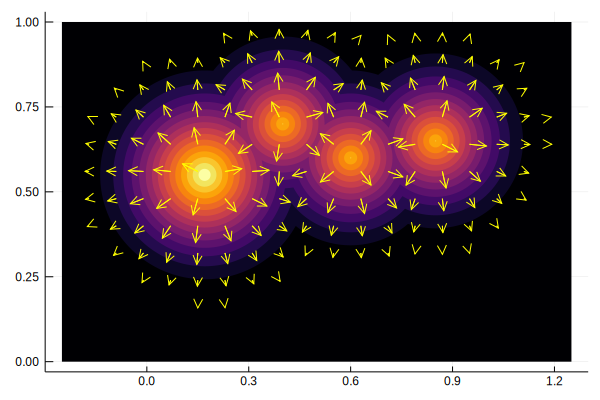

In [5]:
using Base.Iterators
xs, ys = meshgrid(x_min:0.08:x_max, y_min:0.08:y_max)
gradient = hcat([distance_grad(x, y) for (x, y) ∈ zip(xs, ys)]...) * 0.05

gr()
x = range(x_min, x_max, length=1000)
y = range(y_min, y_max, length=1000)
Plots.contour(x, y, (x, y) -> c(SVector(x, y)), fill=true, line=false, legend=nothing, aspect_ratio=:equal)
quiver!(xs, ys, gradient=(gradient[1, :], gradient[2, :]), c=:yellow)

In [38]:
function static_backdrop()
    drawing = Drawing(img_width, img_height, :png, "backdrop.png")
    cm = cmap("L17")
    Δs = 0.001
    Luxor.translate(0, img_height)
    Luxor.scale(img_height, -img_height)
    Luxor.translate(-x_min, -y_min)
    for x ∈ x_min:Δs:x_max
        for y ∈ y_min:Δs:y_max
        dist = c(SVector(x, y))
        sethue(cm[convert(UInt16, clamp(floor(dist * 1500), 1, 256))])
        box(Point(x, y), Point(x + Δs, y + Δs), :fill)
        end
    end
    for obs ∈ obstacles
        sethue("black")
        circle(Point(obs[1], obs[2]), obs[3], :stroke)
    end
    finish()
    return drawing
end

bg = static_backdrop()
bg = readpng(bg.filename);

┌ Warning: interpolate(A, BSpline(Interpolations.Linear()), Interpolations.OnCell()) is deprecated, use interpolate(A, BSpline(Interpolations.Linear()))
│   caller = equalisecolourmap(::String, ::Adjoint{Float64,Array{Float64,2}}, ::String, ::Array{Float64,1}, ::Float64, ::Bool, ::Bool) at cmap.jl:2140
└ @ PerceptualColourMaps C:\Users\eric-\.julia\packages\PerceptualColourMaps\SOi8z\src\cmap.jl:2140
┌ Warning: `getindex(itp::AbstractInterpolation{T, N}, i::Vararg{Number, N}) where {T, N}` is deprecated, use `itp(i...)` instead.
│   caller = #3 at none:0 [inlined]
└ @ Core .\none:0
┌ Warning: `getindex(itp::AbstractInterpolation{T, N}, i::Vararg{Number, N}) where {T, N}` is deprecated, use `itp(i...)` instead.
│   caller = #3 at none:0 [inlined]
└ @ Core .\none:0
┌ Warning: interpolate(A, BSpline(Interpolations.Constant()), Interpolations.OnCell()) is deprecated, use interpolate(A, BSpline(Interpolations.Constant()))
│   caller = equalisecolourmap(::String, ::Adjoint{Float64,Array{Floa

### Robot Arm Kinematics

In [7]:
arm_length = 0.2
arm_diameter = 0.02
base_frame = SMatrix{3,3}([
    1. 0. 0.5;
    0. 1. 0.2;
    0. 0. 1.
])
const DOF = 3

# Forward kinematics
function kin(q, base_tf=base_frame, θ=arm_length)
    dof = length(q)
    tf = base_tf
    for d ∈ 1:dof
        tf *= @SMatrix[cos(q[d]) -sin(q[d]) 0.;
                       sin(q[d]) cos(q[d]) 0.;
                       0. 0. 1.]
        tf *= @SMatrix[1. 0. θ;
                       0. 1. 0.;
                       0. 0. 1.]
    end
    return tf[1:2, 3]
end

kin (generic function with 3 methods)

In [24]:
using SymPy
q = SVector{DOF}([symbols("q_$i") for i ∈ 1:DOF])
kin_q = SymPy.simplify.(kin(q))

2-element Array{Sym,1}:
 0.2*cos(q_1) + 0.2*cos(q_1 + q_2) + 0.2*cos(q_1 + q_2 + q_3) + 0.5
 0.2*sin(q_1) + 0.2*sin(q_1 + q_2) + 0.2*sin(q_1 + q_2 + q_3) + 0.2

Compute analytical Jacobian using SymPy.

In [25]:
SymPy.simplify.(kin_q.jacobian(q))

2×3 Array{Sym,2}:
 -0.2*sin(q_1) - 0.2*sin(q_1 + q_2) - 0.2*sin(q_1 + q_2 + q_3)  …  -0.2*sin(q_1 + q_2 + q_3)
  0.2*cos(q_1) + 0.2*cos(q_1 + q_2) + 0.2*cos(q_1 + q_2 + q_3)      0.2*cos(q_1 + q_2 + q_3)

*Lambdify* symbolic expression for the Jacobian to make it an executable function.

In [26]:
jac = lambdify(kin_q.jacobian(q), q)
@time jac(rand(DOF)...)

  0.041483 seconds (36.05 k allocations: 1.908 MiB)


2×3 Array{Float64,2}:
 -0.365573  -0.270967  -0.173691 
  0.450113   0.273904   0.0991541

### Inverse Kinematics (Newton-Raphson method)

In [11]:
demo = Movie(img_width, img_height, "test")
function backdrop(scene, framenumber)
    background("white")
end

function render_robot(q, base_tf=base_frame)
    Luxor.gsave()
    D = length(q)    
    Luxor.translate(base_tf[1, 3], base_tf[2, 3])
    
    point = SVector(0.0, 0.0)
    tf = @SMatrix[1. 0.; 0. 1.]
    for d ∈ 1:D        
        setcolor(0., 0.7, 0.9)
        Luxor.circle(0., 0., arm_diameter/2, :fill)        
        Luxor.rotate(q[d])
        setcolor(.8, .8, .8, .8)
        Luxor.rect(0, -arm_diameter/2, arm_length, arm_diameter, :fill)
        Luxor.translate(arm_length, 0)
    end
    setcolor("orange")
    Luxor.circle(0., 0., arm_diameter/2, :fill)      
    Luxor.grestore()
end

q = SVector{DOF}(rand(DOF))
function frame(scene, framenumber, p_desired)
    global ξ, q
    t = scene.easingfunction(framenumber, 0, 1, scene.framerange.stop)
    origin(Point(0, img_height))
    Luxor.scale(img_height, -img_height)
    Luxor.translate(-x_min, -y_min)
    
    p = kin(q)
    
    sethue("red")
    Luxor.circle(p_desired[1], p_desired[2], arm_diameter/2, :fill)
    
    J = jac(q[1], q[2], q[3])
#     q -= J' * (p - p_desired)
    q -= 0.1 * pinv(J) * (p - p_desired)
    render_robot(q)
end

@suppress begin
Luxor.animate(demo, [
    Scene(demo, backdrop, 0:200),
    Scene(demo, (s, f) -> frame(s, f, SVector(0.1, 0.5)),
        0:50, easingfunction=easeinoutcubic),
    Scene(demo, (s, f) -> frame(s, f, SVector(0.1, 0.6)),
        50:100, easingfunction=easeinoutcubic),
    Scene(demo, (s, f) -> frame(s, f, SVector(0.8, 0.7)),
        100:150, easingfunction=easeinoutcubic),
    Scene(demo, (s, f) -> frame(s, f, SVector(0.6, 0.3)),
        150:200, easingfunction=easeinoutcubic),
    ],
    creategif=true,
    pathname="inverse_kinematics.gif")
display(MIME("text/html"), """<img src="inverse_kinematics.gif"/>""")
end

## CHOMP

Generate input trajectory $\xi$.

In [12]:
# Newton-Raphson method for inverse kinematics
function perfect_ik(p_desired, q, iterations=100)
    for i ∈ 1:iterations
        p = kin(q)
        J = jac(q...)
        q -= 0.1 * pinv(J) * (p - p_desired)
    end
    return q
end

perfect_ik (generic function with 2 methods)

In [13]:
# trajectory is just linear interpolation between two angle positions
q₀ = perfect_ik(SVector(0.1, 0.3), SVector{DOF}(ones(DOF)))
q₁ = perfect_ik(SVector(0.9, 0.3), SVector{DOF}(ones(DOF)))
const T = 100
function trajectory(t)
    α = easeinoutcubic(t, 0, 1, T)
    return (1-α) * q₀ + α * q₁
end

trajectory (generic function with 1 method)

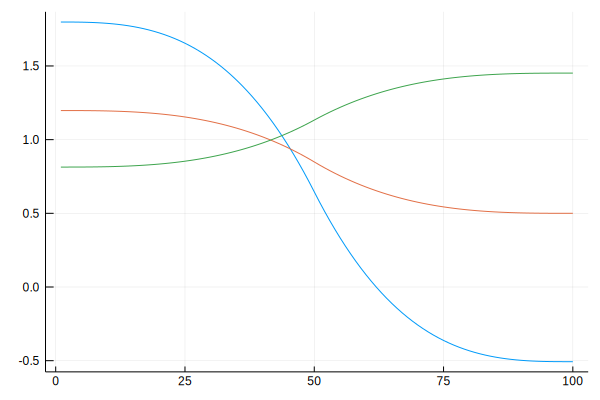

In [14]:
ξ = vcat([trajectory(t) for t ∈ 1:T])
plot([[ξ[t][d] for t ∈ 1:T] for d ∈ 1:DOF]; labels=["\$q_{$d}\$" for d ∈ 1:DOF])

In [39]:
function visualize_trajectory(ξ, name="trajectory")
    @suppress begin
    local T = length(ξ)
    demo = Movie(img_width, img_height, "test")
    local points = [kin(q) for q ∈ ξ]
    function frame(scene, framenumber)
        origin(Point(0, img_height))
        Luxor.scale(img_height, -img_height)
        Luxor.translate(-x_min, -y_min)
        for p ∈ points[1:framenumber]
            setcolor("black")
            circle(p[1], p[2], 0.005, :fill)
        end
        render_robot(ξ[framenumber])
    end


    Luxor.animate(demo, [
        Scene(demo, backdrop, 1:T),
        Scene(demo, frame, 1:T),
        ],
        creategif=true,
        pathname="$name.gif")
    display(MIME("text/html"), """<img src="$name.gif"/>""")
    end
end
visualize_trajectory(ξ, "traj_before")

In [31]:
let
    x(t) = kin(trajectory(t))
    ẋ(t::Real) = transpose(jacobian(central_fdm(2, 1), kin, Vector([t]))[1])
    @show trajectory(5)
    @show x(5)
    @show ẋ(5.)
end

trajectory(5) = [1.7971475875455691, 1.1971653119093137, 0.8141518209086528]
x(5) = [0.10012849647720479, 0.30054168269018855]
ẋ(5.0) = [0.19178485478534343 0.05673243145335536]


1×2 Transpose{Float64,Array{Float64,2}}:
 0.191785  0.0567324

Gradient descent update rule (Equation 19):
$$
\xi_{i+1} = \xi_i - \frac{1}{\eta}A^{-1}\bar{\nabla}\mathfrak{U}[\xi_i]
$$

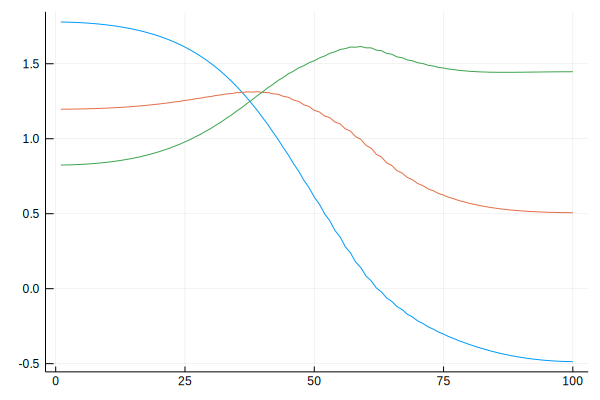

In [41]:
demo = Movie(img_width, img_height, "test")
function backdrop(scene, framenumber)
    placeimage(bg, -bg.width/2, -bg.height/2)
end

let
    # Smooth obstacle gradient
    ∇c(x) = SVector{2}(grad(central_fdm(2, 1), c, x)[1])

    ξ_ = copy(ξ)
    
    # Compute trajectory gradients using waypoint differences
    # (use symmetric derivative instead of left-sided as in the paper)
    x(t) = kin(ξ_[clamp(t, 1, T)])
    ẋ(t) = (x(t+1) - x(t-1))
    ẍ(t) = (ẋ(t+1) - ẋ(t-1))

    ξt(t) = ξ_[clamp(t, 1, T)]
    ξd(t) = (ξt(t+1) - ξt(t-1))
    ξdd(t) = (ξd(t+1) - ξd(t-1))

    function frame(scene, framenumber)
        global ξ_
        origin(Point(0, img_height))
        Luxor.scale(img_height, -img_height)
        Luxor.translate(-x_min, -y_min)
        for t ∈ 1:T
            sethue("black")
            xₜ = kin(ξ_[t])
            distance = c(xₜ)
            
            ẋ̂ = LinearAlgebra.normalize(ẋ(t))
            
            # Equation 26 (curvature)
            κ = (1 / (norm(ẋ(t))^2 + 0.01) * (I - ẋ̂ *transpose(ẋ̂ )) * ẍ(t))
            
            # Equation 25
            ∇U = jac(ξ_[t]...)' * (norm(ẋ(t)) * (I - ẋ̂ *transpose(ẋ̂ )) * ∇c(xₜ) - c(xₜ) * κ)
            ∇U -= 0.5 * ξdd(t)  # smoothness term
            
            p = kin(ξ_[t])
            circle(Point(p[1], p[2]), 0.005, :fill)
            
            ξ_[t] -= 0.2 * ∇U
        end
    end

    @suppress begin
    Luxor.animate(demo, [
        Scene(demo, backdrop, 0:150),
        Scene(demo, frame, 0:150,
            easingfunction=easeinoutcubic,
            optarg=q)
        ],
        creategif=true,
        pathname="chomp.gif")
    display(MIME("text/html"), """<img src="chomp.gif"/>""")
    end
    
    visualize_trajectory(ξ_, "traj_after")
    
    plot([[ξ_[t][d] for t ∈ 1:T] for d ∈ 1:DOF]; labels=["\$q_{$d}\$" for d ∈ 1:DOF])
end